In [1]:
import numpy as np
import pandas as pd
import math
import itertools

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load and process the data

In [3]:
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
y = pd.Series(data=df['Passengers'].values, index=df['Month'])
y.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
dtype: int64

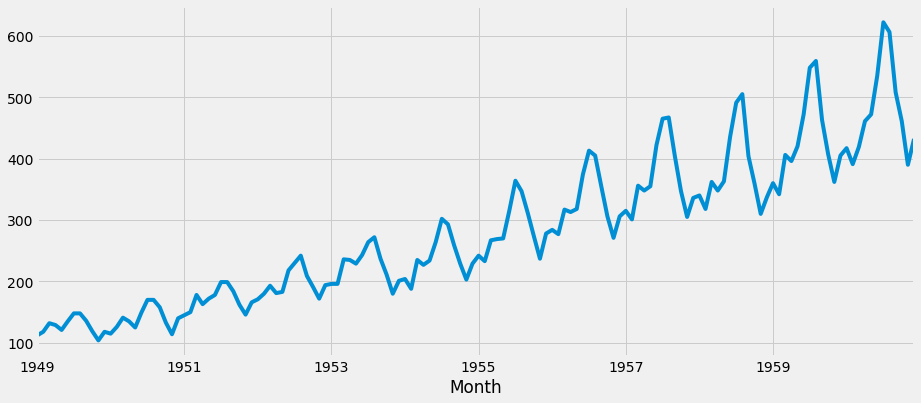

In [5]:
y.plot(figsize=(14, 6))
plt.show()

In [6]:
data = y.values.reshape(y.size,1)

# LSTM Forecast Model

### LSTM Data Preparation

In [7]:
'MixMaxScaler'
scaler = MinMaxScaler(feature_range=(0, 1))
data   = scaler.fit_transform(data)

In [8]:
train_size  = int(len(data) * 0.7)
test_size   = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print('data train size :',train.shape[0])
print('data test size  :',test.shape[0])

data train size : 100
data test size  : 44


In [9]:
'function to reshape data according to the number of lags'

def reshape_data (data, look_back,time_steps):
    
    sub_seqs = int(look_back/time_steps)
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    
    dataX = np.reshape(dataX,(dataX.shape[0],sub_seqs,time_steps,np.size(data,1)))
    return dataX, dataY

In [10]:
look_back = 2
time_steps = 1

trainX, trainY = reshape_data(train, look_back,time_steps)
testX, testY = reshape_data(test, look_back,time_steps)
print('train shape :',trainX.shape)
print('test shape  :',testX.shape)

train shape : (97, 2, 1, 1)
test shape  : (41, 2, 1, 1)


## Define and Fit  the Model

In [11]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, time_steps, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(trainX, trainY, epochs=300, validation_data=(testX, testY), verbose=0)

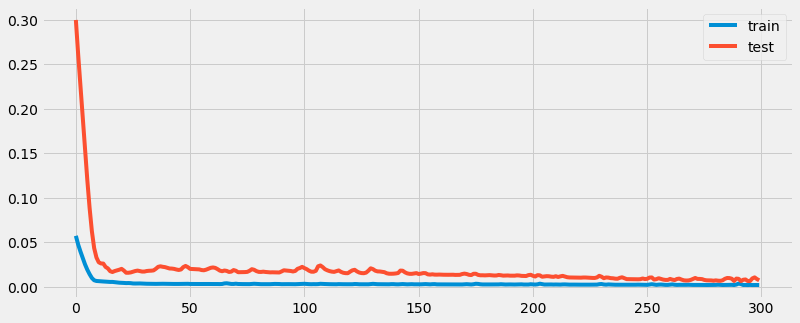

In [12]:
'plot history'
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test the performances

In [13]:
'make predictions'
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [22]:
'invert predictions'
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [23]:
'calculate root mean squared error' 
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.57 RMSE
Test Score: 43.94 RMSE


In [24]:
'shift train predictions for plotting'
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

'shift test predictions for plotting'
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

In [25]:
'Make as pandas series to plot'
data_series = pd.Series(scaler.inverse_transform(data).ravel(), index=df['Month'])
trainPredict_series = pd.Series(trainPredictPlot.ravel(), index=df['Month'])
testPredict_series  = pd.Series(testPredictPlot.ravel(), index=df['Month'])

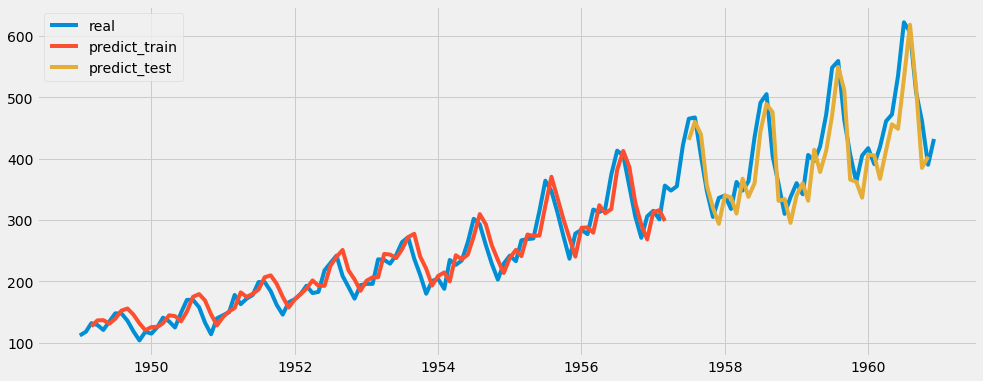

In [26]:
'plot baseline and predictions'
plt.figure(figsize=(15,6))
plt.plot(data_series,label = 'real')
plt.plot(trainPredict_series,label = 'predict_train')
plt.plot(testPredict_series,label = 'predict_test')
plt.legend()
plt.show()

## Forecasting 

In [106]:
rows = testX[:4]

In [107]:
def forecast_cnn_lstm (model, rows, steps, look_back,time_steps) :
    
    predictions = []
    
    data = model.predict(rows)
    dataX,_ = reshape_data(data, look_back,time_steps)
    val = model.predict(dataX)[0]
    predictions.append(val)
    
    for i in range(steps) :
    
        #print(data,'\n')
        data[:-1] = data[1:]
        data[-1] = val
        dataX,_ = reshape_data(data, look_back,time_steps)
        val = model.predict(dataX)[0]
        predictions.append(val)
    
    return np.asarray(predictions)
        

In [108]:
predictions = forecast_cnn_lstm (model, rows, 40, look_back,time_steps)

In [109]:
a = scaler.inverse_transform(predictions)

In [112]:
a

array([[448.79092 ],
       [405.73315 ],
       [313.33    ],
       [464.70773 ],
       [368.90433 ],
       [280.43976 ],
       [482.42487 ],
       [314.26648 ],
       [259.58987 ],
       [489.1188  ],
       [239.0064  ],
       [254.64713 ],
       [488.8441  ],
       [153.8007  ],
       [263.06805 ],
       [487.06744 ],
       [ 74.7601  ],
       [261.26422 ],
       [488.04608 ],
       [ 40.16603 ],
       [234.34692 ],
       [488.38232 ],
       [ 38.48628 ],
       [211.72644 ],
       [480.30634 ],
       [ 38.254253],
       [194.04216 ],
       [465.34656 ],
       [ 43.142376],
       [179.71616 ],
       [444.76572 ],
       [ 51.81848 ],
       [168.36652 ],
       [419.96094 ],
       [ 62.843174],
       [158.86414 ],
       [393.43817 ],
       [ 74.762825],
       [151.34222 ],
       [367.03232 ],
       [ 86.63112 ]], dtype=float32)

# SARIMA Model

In [ ]:
y_train = y[:train_size]
y_test  = y[train_size:]

## Grid search the p, d, q parameters

In [ ]:
'Define the p, d and q parameters to take any value between 0 and 3'
p = d = q = range(0, 3)

'Generate all different combinations of p, q and q triplets'
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        mod = sm.tsa.statespace.SARIMAX(y_train,order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
            
        print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

        if results.aic < best_result[2]:
            best_result = [param, param_seasonal, results.aic]
print('\nBest Result:', best_result)

## Plot model diagnostics

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(best_result[0][0], best_result[0][1], best_result[0][2]),
                                seasonal_order=(best_result[1][0], best_result[1][1], best_result[1][2], best_result[1][3]),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
'make predictions'
pred = results.get_prediction(start=pd.to_datetime('1949-02-01'), dynamic=False,full_results=True)
pred_ci = pred.conf_int()

In [ ]:
ax = y_train.plot(label='Observed', figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')
plt.legend()

plt.show()

In [ ]:
pred_uc = results.get_forecast(steps=44)

In [ ]:
ax = y_train.plot(label='train', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
y_test.plot(ax=ax, label='test')
ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')

plt.legend()
plt.show()

In [ ]:
trainScore = math.sqrt(mean_squared_error(y_train[1:], pred.predicted_mean))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(y_test, pred_uc.predicted_mean))
print('Test Score: %.2f RMSE' % (testScore))